In [ ]:
class path:
    CM_imagePath = './image/annAbnormalConfusionMatrix.jpg'
    data_dir = data_dir = './Datasets/abnormal'
    AccLoss_imagePath = './image/MLP_Abnormal_AccLoss.jpg'

In [ ]:
## MLP
import os
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler


# -------------------------------------------------
# 滑动窗口
# -------------------------------------------------
def sliding_window(data, label, window_size=20, step_size=10):
    X, y = [], []
    T = data.shape[0]

    for start in range(0, T - window_size + 1, step_size):
        end = start + window_size
        X.append(data[start:end])
        y.append(label)

    return np.array(X), np.array(y)


# -------------------------------------------------
# 主函数：每个 CSV 内部做时间切分
# -------------------------------------------------
def load_dataset(root_dir,
                 window_size=20,
                 step_size=10,
                 train_ratio=0.6,
                 val_ratio=0.2):
    """
    每个 CSV:
        1) 时间切分 train / val / test
        2) 各自滑窗
        3) 最终合并
    """

    label_map = {
        'Lhemiplegia': 0,
        'Rhemiplegia': 1,
        'normal': 2,
        'Parkinson': 3
    }

    X_train_all, y_train_all = [], []
    X_val_all, y_val_all = [], []
    X_test_all, y_test_all = [], []

    csv_files = sorted(glob.glob(os.path.join(root_dir, '*.csv')))
    if len(csv_files) == 0:
        raise RuntimeError('未找到 CSV 文件')

    # -------------------------------------------------
    # 第一遍：收集 train 数据用于归一化
    # -------------------------------------------------
    train_sensor_pool = []

    for csv_file in csv_files:
        df = pd.read_csv(csv_file, skiprows=1)

        sensor_data = df.iloc[:, 0:4].values.astype(np.float32)
        T = len(sensor_data)

        t_train = int(T * train_ratio)

        train_sensor_pool.append(sensor_data[:t_train])

    train_sensor_pool = np.vstack(train_sensor_pool)

    scaler = MinMaxScaler()
    scaler.fit(train_sensor_pool)

    # -------------------------------------------------
    # 第二遍：正式构造数据集
    # -------------------------------------------------
    for csv_file in csv_files:
        df = pd.read_csv(csv_file, skiprows=1)

        sensor_data = df.iloc[:, 0:4].values.astype(np.float32)
        sensor_data = scaler.transform(sensor_data)

        raw_label = df.iloc[0, -1]
        label = label_map[raw_label]

        T = len(sensor_data)
        t_train = int(T * train_ratio)
        t_val = int(T * (train_ratio + val_ratio))

        data_train = sensor_data[:t_train]
        data_val = sensor_data[t_train:t_val]
        data_test = sensor_data[t_val:]

        X_tr, y_tr = sliding_window(data_train, label, window_size, step_size)
        X_va, y_va = sliding_window(data_val, label, window_size, step_size)
        X_te, y_te = sliding_window(data_test, label, window_size, step_size)

        X_train_all.append(X_tr)
        y_train_all.append(y_tr)

        X_val_all.append(X_va)
        y_val_all.append(y_va)

        X_test_all.append(X_te)
        y_test_all.append(y_te)

    X_train = np.concatenate(X_train_all)
    y_train = np.concatenate(y_train_all)
    X_val = np.concatenate(X_val_all)
    y_val = np.concatenate(y_val_all)
    X_test = np.concatenate(X_test_all)
    y_test = np.concatenate(y_test_all)

    return X_train, X_val, X_test, y_train, y_val, y_test




X_train, X_val, X_test, y_train, y_val, y_test = load_dataset(
    root_dir=path.data_dir,
    window_size=20,
    step_size=10
)

print('Train:', X_train.shape, np.unique(y_train))
print('Val  :', X_val.shape, np.unique(y_val))
print('Test :', X_test.shape, np.unique(y_test))



In [ ]:
model = Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2])),

    Flatten(),

    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),

    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),

    Dense(4, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=300,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f'Test accuracy: {test_acc:.4f}')



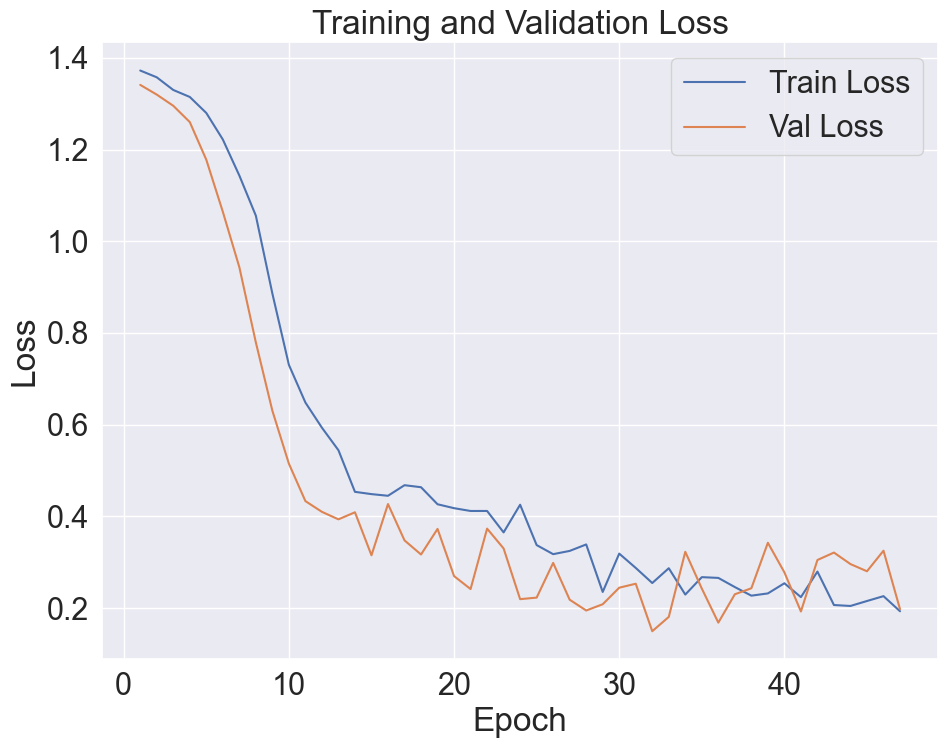

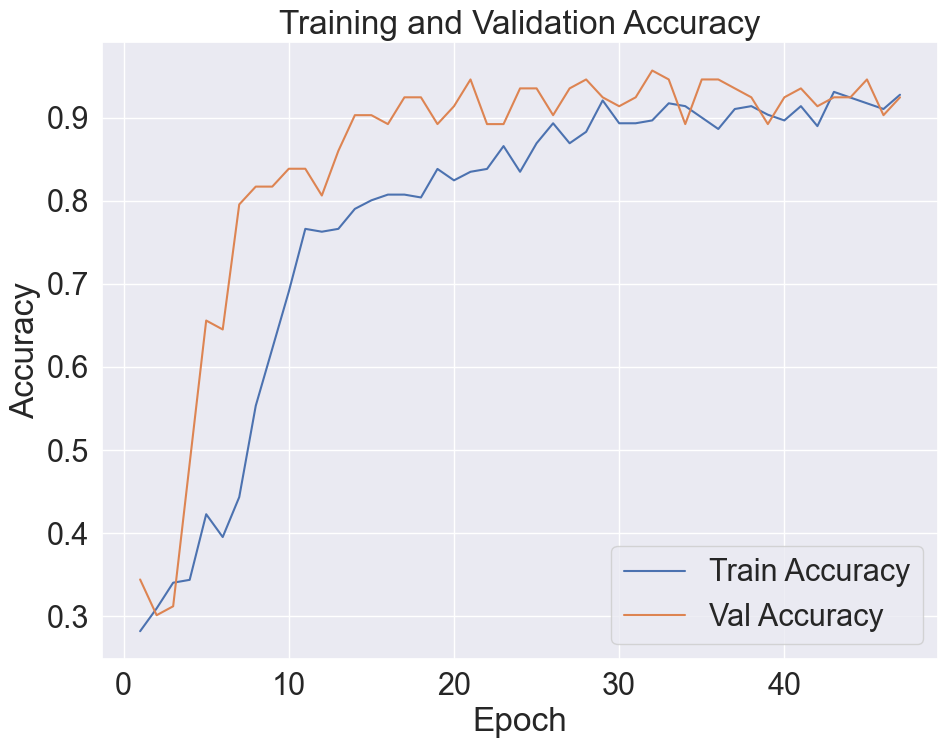

In [18]:
import matplotlib.pyplot as plt


def plot_training_curves(history):
    history_dict = history.history
    epochs = range(1, len(history_dict['loss']) + 1)

    # -------- Loss --------
    plt.figure(figsize=(10, 8))
    plt.plot(epochs, history_dict['loss'], label='Train Loss')
    plt.plot(epochs, history_dict['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # -------- Accuracy --------
    plt.figure(figsize=(10, 8))
    plt.plot(epochs, history_dict['accuracy'], label='Train Accuracy')
    plt.plot(epochs, history_dict['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    plt.savefig(path.AccLoss_imagePath, dpi=500, bbox_inches='tight')
    plt.show()



plot_training_curves(history)


3/3 [==============================] - 0s 2ms/step


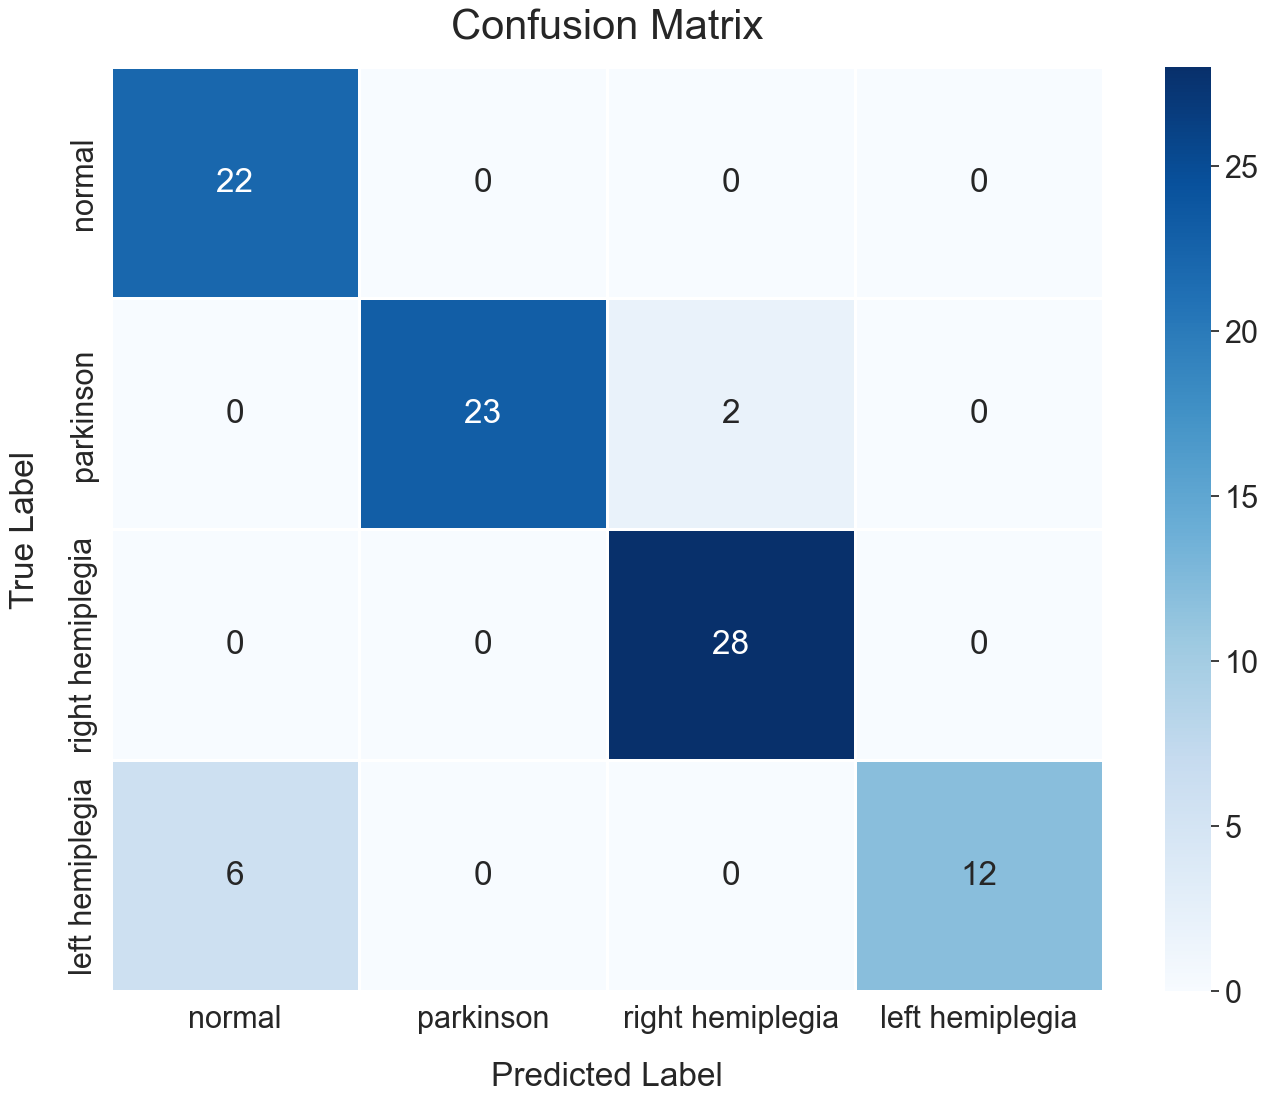

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

# -------------------------------------------------
# 预测
# -------------------------------------------------
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=-1)
y_true = y_test

# -------------------------------------------------
# 混淆矩阵
# -------------------------------------------------
matrix = metrics.confusion_matrix(y_true, y_pred)

labels = ["normal", "parkinson", "right hemiplegia", "left hemiplegia"]

plt.figure(figsize=(16, 12))
sns.set_theme(style="whitegrid", font='Times New Roman', font_scale=1.4)
sns.set(font_scale=2)

sns.heatmap(
    matrix,
    cmap="Blues",
    linecolor='white',
    linewidths=1,
    xticklabels=labels,
    yticklabels=labels,
    annot=True,
    fmt="d"
)

plt.title("Confusion Matrix", fontdict={'size': 30}, pad=20)
plt.ylabel("True Label", fontdict={'size': 24}, labelpad=20)
plt.xlabel("Predicted Label", fontdict={'size': 24}, labelpad=20)

CM_imagePath = './image/MLP_Abnormal_CM.jpg'
plt.savefig(path.CM_imagePath, dpi=500, bbox_inches='tight')
plt.show()
